In [45]:
import torch, time
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [7]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [8]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [9]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

In [10]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [11]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

In [12]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   pickup_datetime    120000 non-null  object        
 1   fare_amount        120000 non-null  float64       
 2   fare_class         120000 non-null  int64         
 3   pickup_longitude   120000 non-null  float64       
 4   pickup_latitude    120000 non-null  float64       
 5   dropoff_longitude  120000 non-null  float64       
 6   dropoff_latitude   120000 non-null  float64       
 7   passenger_count    120000 non-null  int64         
 8   dist_km            120000 non-null  float64       
 9   EDTdate            120000 non-null  datetime64[ns]
 10  Hour               120000 non-null  category      
 11  AMorPM             120000 non-null  category      
 12  Weekday            120000 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(6

In [15]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [16]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [17]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [18]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [19]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [20]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

In [21]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [22]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [23]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [24]:
conts.type()

'torch.FloatTensor'

In [25]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [26]:
cats.shape

torch.Size([120000, 3])

In [27]:
conts.shape

torch.Size([120000, 6])

In [28]:
y.shape

torch.Size([120000, 1])

In [29]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [30]:
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [31]:
# This is passed in when the model is instantiated
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [32]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [33]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [34]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[ 0.5887,  1.0968,  1.7170, -0.2125, -0.6012, -0.7560,  0.4535, -0.0721,
           0.4227, -1.0538, -0.8128,  0.0713],
         [ 0.0133,  1.4745,  1.3448,  0.3480,  1.3815,  0.0689, -0.4350,  0.0958,
           0.3877,  1.3446, -0.2347, -1.4724],
         [ 1.9565,  0.8743, -0.9420,  0.4899,  0.2081, -0.4207,  0.8509,  0.1066,
          -1.1714,  1.2106, -0.9430,  0.3469],
         [ 0.3647,  1.1245, -0.8873, -0.3941,  1.1462,  1.1251,  0.8658,  0.3455,
          -1.0772,  0.1444,  0.9299,  0.5359]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.9400],
         [ 0.9400],
         [ 0.9400],
         [-0.0863]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.6486, -0.9222, -0.3680,  0.4088],
         [-0.9531, -0.0768,  0.0111,  0.2882],
         [-0.9531, -0.0768,  0.0111,  0.2882],
         [-0.6286,  0.1445, -0.1978, -0.8700]], grad_fn=<EmbeddingBackward0>)]

In [35]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[ 0.5887,  1.0968,  1.7170, -0.2125, -0.6012, -0.7560,  0.4535, -0.0721,
          0.4227, -1.0538, -0.8128,  0.0713,  0.9400,  0.6486, -0.9222, -0.3680,
          0.4088],
        [ 0.0133,  1.4745,  1.3448,  0.3480,  1.3815,  0.0689, -0.4350,  0.0958,
          0.3877,  1.3446, -0.2347, -1.4724,  0.9400, -0.9531, -0.0768,  0.0111,
          0.2882],
        [ 1.9565,  0.8743, -0.9420,  0.4899,  0.2081, -0.4207,  0.8509,  0.1066,
         -1.1714,  1.2106, -0.9430,  0.3469,  0.9400, -0.9531, -0.0768,  0.0111,
          0.2882],
        [ 0.3647,  1.1245, -0.8873, -0.3941,  1.1462,  1.1251,  0.8658,  0.3455,
         -1.0772,  0.1444,  0.9299,  0.5359, -0.0863, -0.6286,  0.1445, -0.1978,
         -0.8700]], grad_fn=<CatBackward0>)

In [36]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [37]:
z = selfembdrop(z)
z

tensor([[ 0.9811,  1.8280,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
          0.0000, -0.0000, -1.3546,  0.0000,  0.0000,  1.0809, -1.5370, -0.0000,
          0.6813],
        [ 0.0221,  2.4575,  2.2413,  0.0000,  0.0000,  0.1148, -0.7251,  0.0000,
          0.6461,  0.0000, -0.3911, -2.4540,  1.5667, -1.5885, -0.1280,  0.0185,
          0.4804],
        [ 3.2608,  0.0000, -1.5700,  0.0000,  0.3469, -0.7011,  1.4181,  0.0000,
         -1.9523,  2.0177, -1.5716,  0.5782,  1.5667, -1.5885, -0.1280,  0.0185,
          0.4804],
        [ 0.0000,  0.0000, -1.4788, -0.6568,  1.9103,  0.0000,  1.4431,  0.5759,
         -1.7953,  0.0000,  1.5498,  0.0000, -0.1439, -0.0000,  0.2408, -0.0000,
         -1.4500]], grad_fn=<MulBackward0>)

In [49]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        total_embeddings = sum((nf for ni,nf in emb_szs))
        n_in = total_embeddings + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [50]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [51]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [52]:
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [54]:
len(cat_train)

48000

In [55]:
len(cat_test)

12000

In [56]:
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) 
    losses.append(loss.item())
    
    if i%25 == 0:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Time elapsed in ANN model training: {(time.time()-start_time)/60} minutes.")

epoch:  25  loss: 10.94479084
epoch:  50  loss: 10.24611092
epoch:  75  loss: 9.75775337
epoch: 100  loss: 9.22014904
epoch: 125  loss: 8.46297836
epoch: 150  loss: 7.46166849
epoch: 175  loss: 6.29497051
epoch: 200  loss: 5.08745193
epoch: 225  loss: 4.24205875
epoch: 250  loss: 3.89034081
epoch: 275  loss: 3.76449680
epoch: 300  loss: 3.72284532
Time elapsed in ANN model training: 5.275782827536265 minutes.


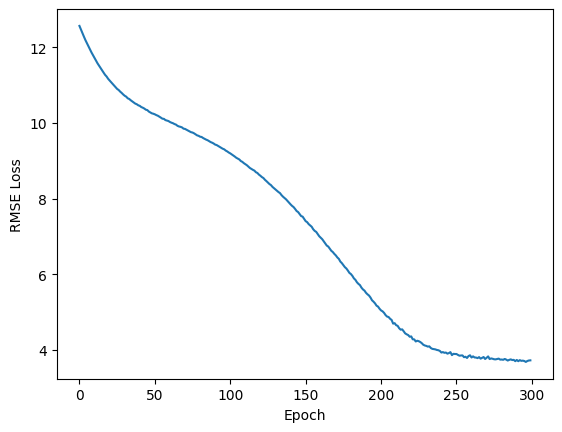

In [57]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('Epoch');

In [58]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
    
print(f"RMSE: {loss:.8f}")

RMSE: 3.63411498


In [59]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.4228   2.9000   1.5228
 2.  13.9249   5.7000   8.2249
 3.   6.6260   7.7000   1.0740
 4.  14.8741  12.5000   2.3741
 5.   6.1534   4.1000   2.0534
 6.   5.3523   5.3000   0.0523
 7.   4.9461   3.7000   1.2461
 8.  19.9763  14.5000   5.4763
 9.   9.1338   5.7000   3.4338
10.  12.6256  10.1000   2.5256
11.   7.8499   4.5000   3.3499
12.   1.4249   6.1000   4.6751
13.   6.9105   6.9000   0.0105
14.  11.2896  14.1000   2.8104
15.   4.5907   4.5000   0.0907
16.  32.8177  34.1000   1.2823
17.   1.4207  12.5000  11.0793
18.   6.5123   4.1000   2.4123
19.   7.2892   8.5000   1.2108
20.   4.0630   5.3000   1.2370
21.  14.8299  11.3000   3.5299
22.   9.7820  10.5000   0.7180
23.  17.4896  15.3000   2.1896
24.  16.8448  14.9000   1.9448
25.  46.3393  49.5700   3.2307
26.   1.9392   5.3000   3.3608
27.   4.2163   3.7000   0.5163
28.   4.9541   6.5000   1.5459
29.  14.7495  14.1000   0.6495
30.   6.2543   4.9000   1.3543
31.   3.9898   3.7000   0.2898
32.  31.

In [60]:
if len(losses) == epochs:
    torch.save(model.state_dict(), 'taxi_fare_predictor.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [61]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

In [62]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

In [63]:
model2.load_state_dict(torch.load('taxi_fare_predictor.pt'));
model2.eval() 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7900\2686535573.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('taxi_fare_predictor.pt'));

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [66]:
def test_data(model): 
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])

    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = model(xcats, xconts)
        
    print(f"\nThe predicted fare amount is ${z.item():.2f}.")

In [67]:
z = test_data(model2)

What is the pickup latitude?   40.5
What is the pickup longitude?  -73.9
What is the dropoff latitude?   40.52
What is the dropoff longitude?  -73.92
How many passengers?  2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS      2010-04-15 16:00:00



The predicted fare amount is $16.66.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7900\2936643381.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
